In [4]:
# https://www.kaggle.com/khacnghia97/recommend-ligthfm
# https://www.kaggle.com/victorbonilla/factorization-machine-recommender-in-sagemaker
# https://www.kaggle.com/ccromer/recommender-system-project
# https://www.kaggle.com/victorbonilla/apriori-recommender-system

In [5]:
import pandas as pd
import numpy as np
import random
import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import implicit
import scipy

In [6]:
events_df = pd.read_csv('events_example.csv')
retail = pd.read_csv('retail.csv')

In [7]:
#Which event has a value in its transaction id
events_df[events_df.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

In [8]:
#Which event/s has a null value
events_df[events_df.transactionid.isnull()].event.unique()

array(['view', 'addtocart'], dtype=object)

# Recommend using apriori method

In [9]:
#Let's get all the customers who bought something
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [10]:
#Let's get all unique visitor ids as well
all_customers = events_df.visitorid.unique()
all_customers.size

1407580

In [11]:
#Customers who just browsed
customer_browsed = [x for x in all_customers if x not in customer_purchased]

In [12]:
len(customer_browsed)

1395861

In [13]:
#A sample list of the customers who bought something
customer_purchased[:10]

array([ 599528,  121688,  552148,  102019,  189384,  350566,  404403,
        505565,  945184, 1406787])

In [14]:
events_df[events_df.visitorid == 102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
19690,1433175714335,102019,view,49521,NaN
19501,1433175801314,102019,addtocart,49521,NaN
14842,1433175812596,102019,view,150318,NaN
19573,1433175871497,102019,view,49521,NaN
8701,1433175894837,102019,view,49521,NaN
19708,1433175945872,102019,view,150318,NaN
8740,1433176042269,102019,view,49521,NaN
814,1433176736375,102019,transaction,150318,13556.0
19724,1433176736422,102019,transaction,49521,13556.0


In [15]:
tz = int('1433221332')
new_time = datetime.datetime.fromtimestamp(tz)
new_time.strftime('%Y-%m-%d %H:%M:%S')

'2015-06-02 06:02:12'

In [16]:
tz = int('1438400163')
new_time = datetime.datetime.fromtimestamp(tz)
new_time.strftime('%Y-%m-%d %H:%M:%S')

'2015-08-01 04:36:03'

In [17]:
# Firstly let's create an array that lists visitors who made a purchase
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
    
purchased_items = []
    
# Create another list that contains all their purchases 
for customer in customer_purchased:

    #Generate a Pandas series type object containing all the visitor's purchases and put them in the list
    purchased_items.append(list(events_df.loc[(events_df.visitorid == customer) & (events_df.transactionid.notnull())].itemid.values))                                  


In [18]:
purchased_items[:5]

[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044]]

In [19]:
# Number of unique items in transactions
events_df.loc[events_df.transactionid.notnull(), 'itemid'].unique().size

12025

In [20]:
max_len=0
item_no = []
for tran in purchased_items:
    item_no.append(len(tran))
    if len(tran) > max_len:
        max_len = len(tran)
        
print(f'Biggest purchase size: {max_len} items')

Biggest purchase size: 559 items


In [21]:
#Encode purchase items
te = TransactionEncoder()
te_ary = te.fit(purchased_items).transform(purchased_items)
df_pi = pd.DataFrame(te_ary, columns=te.columns_)
df_pi.shape

(11719, 12025)

In [22]:
df_pi.head()

,15,19,25,42,147,168,199,212,233,304,...,466319,466321,466342,466443,466464,466526,466603,466614,466710,466861
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
#Items bought frequency
frq_items = apriori(df_pi, min_support=0.001)
frq_items.head()

,support,itemsets
0,0.001707,(14)
1,0.003925,(185)
2,0.001792,(244)
3,0.001451,(264)
4,0.001024,(299)


In [24]:
rules = association_rules(frq_items, metric ="confidence", min_threshold = 0.4)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(11484),(5436),0.003584,0.006827,0.003072,0.857143,125.560714,0.003047,6.952214
1,(5436),(11484),0.006827,0.003584,0.003072,0.450000,125.560714,0.003047,1.811666


In [25]:
# Write a function that would show items that were bought together (same of different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

In [26]:
events_df['itemid'][1]

248676

In [27]:
#Test recomendation system with sample itemid
recommender_bought_bought(events_df['itemid'][1], purchased_items)

[464385, 31611, 66509, 348053]

## Data Analysis

In [28]:
a=retail.groupby(['Country']).count()['Quantity']
a=np.log(a)
a=a.to_frame()
a.sort_values('Quantity',inplace=True)

<AxesSubplot:title={'center':'Distribution of Countries by Items Bought'}, ylabel='Country'>

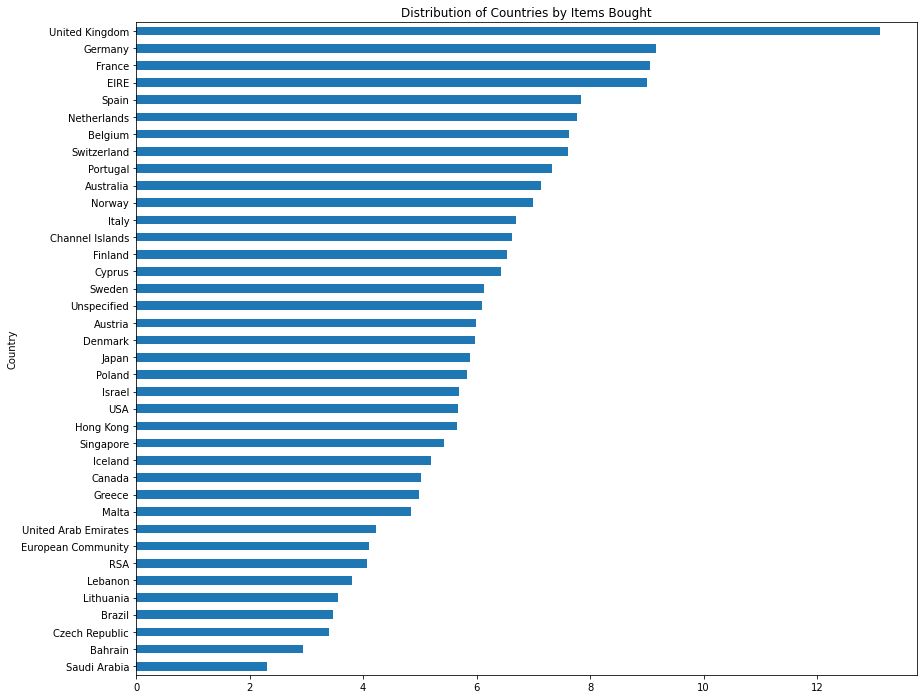

In [29]:
#Plot the Distribution of Countries by Items Bought
a['Quantity'].plot(kind="barh",figsize=(14,12),title='Distribution of Countries by Items Bought')

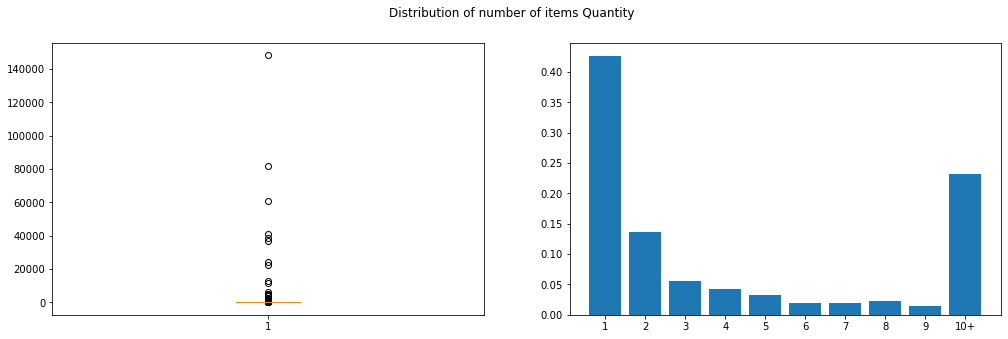

57.34% of customers have more than 1 product bought


In [30]:
# Distribution of number of items Quantity
data1 = retail['Quantity'].value_counts()  # count of events per Quantity
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  # count of counts of events per Quantity

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,11)))
ax2.set_xticklabels(list(range(1,10)) +['10+'])
fig.suptitle("Distribution of number of items Quantity")

plt.show()
print("{0:.2f}% of customers have more than 1 product bought".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

In [31]:
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


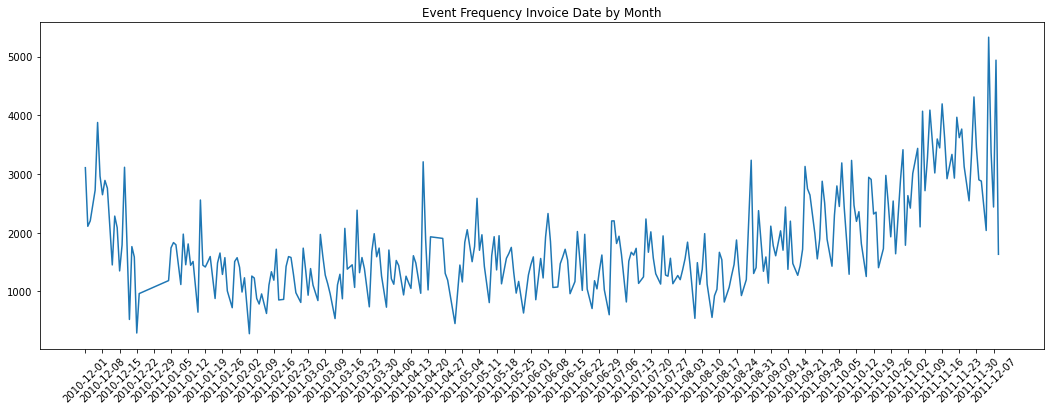

In [32]:
# Visualize number of events per month
data = pd.DatetimeIndex(retail['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(18,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.title('Event Frequency Invoice Date by Month')
plt.show()

# Recommend using Implicit model

Retail recommend

In [33]:
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [34]:
retail.dropna(axis=1,how='all', inplace=True)

In [35]:
retail['StockCode'] = retail['StockCode'].apply(lambda x: x[:5])

In [36]:
def make_numeric(x):
    try:
        return int(x)
    except:
        return 0

retail['StockCode'] = retail['StockCode'].map(make_numeric)
retail['CustomerID'] = retail['CustomerID'].map(make_numeric)

In [37]:
# initialize a model
model_retail = implicit.als.AlternatingLeastSquares(factors=50)

In [38]:
sparse_mat_retail = scipy.sparse.coo_matrix((retail.index, (retail.StockCode, retail.CustomerID)))

In [39]:
# train the model on a sparse matrix of item/user/confidence weights
model_retail.fit(sparse_mat_retail)

In [40]:
# recommend items for a user
user_items_retail = sparse_mat_retail.T.tocsr()

In [42]:
#recommend using visitor id
model_retail.recommend(17850, user_items_retail)

[(22617, 1.1222906),
 (22081, 1.1149516),
 (21700, 1.1039279),
 (22955, 1.096859),
 (21928, 1.092406),
 (22082, 1.0902066),
 (85049, 1.0823736),
 (82580, 1.0730476),
 (84279, 1.0718778),
 (85194, 1.0717933)]

In [43]:
# find related items
model_retail.similar_items(23254)

[(23254, 1.0000001),
 (23256, 0.9955518),
 (22998, 0.98769855),
 (23255, 0.9859418),
 (20983, 0.9859127),
 (23308, 0.98401964),
 (23192, 0.9831796),
 (22037, 0.9828945),
 (23191, 0.98280793),
 (23439, 0.9825521)]

Event database recommend

In [44]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)

In [45]:
sparse_mat = scipy.sparse.coo_matrix((events_df.index, (events_df.itemid, events_df.visitorid)))

In [46]:
# train the model on a sparse matrix of item/user/confidence weights
model.fit(sparse_mat)

In [47]:
# recommend items for a user
user_items = sparse_mat.T.tocsr()

In [48]:
#recommend using visitor id
model.recommend(customer_purchased[20], user_items)

[(176385, 0.58332276),
 (432409, 0.5478548),
 (394254, 0.5376461),
 (222045, 0.5289852),
 (77737, 0.52221215),
 (59828, 0.5161735),
 (42542, 0.5143831),
 (11974, 0.5130818),
 (31199, 0.50358117),
 (128547, 0.5026322)]

In [49]:
# find related items
model.similar_items(318965)

[(318965, 1.0000001),
 (12960, 0.6739312),
 (225925, 0.6719628),
 (25447, 0.67089695),
 (36942, 0.66644186),
 (346019, 0.6469897),
 (182673, 0.6421234),
 (83275, 0.6342269),
 (341090, 0.63396716),
 (39343, 0.6320665)]

In [50]:
#Compare two methods
item = events_df['itemid'][1]
method1 = recommender_bought_bought(item, purchased_items)
method2 =model.similar_items(item)
print(method1)
print(method2)

[464385, 31611, 66509, 348053]
[(248676, 0.99999994), (378879, 0.8854874), (169601, 0.88283694), (447893, 0.8807949), (228075, 0.8805791), (124874, 0.8735262), (88202, 0.8709032), (443103, 0.86945605), (378857, 0.86821693), (81418, 0.86813766)]


# Evaluation

In [51]:
#Put all the visitor id in an array and sort it ascendingly
all_visitors = events_df.visitorid.sort_values().unique()
all_visitors.size

1407580

In [52]:
buying_visitors = events_df[events_df.event == 'transaction'].visitorid.sort_values().unique()
buying_visitors.size

11719

In [53]:
viewing_visitors_list = list(set(all_visitors) - set(buying_visitors))

In [54]:
def create_dataframe(visitor_list):
    
    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = events_df[events_df.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)
    
    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])

In [55]:
buying_visitors_df = create_dataframe(buying_visitors)

In [56]:
buying_visitors_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1
3,419,3,4,1,1
4,539,1,4,1,1
...,...,...,...,...,...
11714,1406787,3,20,1,1
11715,1406981,4,4,1,1
11716,1407070,1,1,1,1
11717,1407110,2,7,1,1


In [57]:
buying_visitors_df.shape

(11719, 5)

In [58]:
#Let's shuffle the viewing visitors list for randomnes
random.shuffle(viewing_visitors_list)

In [59]:
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:27820])

In [60]:
viewing_visitors_df.shape

(27820, 5)

In [61]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

In [62]:
#Let's shuffle main_df first
main_df = main_df.sample(frac=1)

/Users/sofia/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


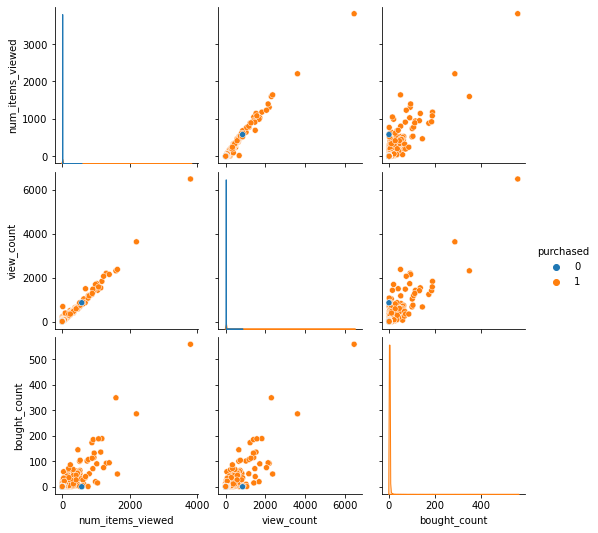

In [63]:
#Plot the data
sns.pairplot(main_df, x_vars = ['num_items_viewed', 'view_count', 'bought_count'],
             y_vars = ['num_items_viewed', 'view_count', 'bought_count'],  hue = 'purchased')

In [64]:
main_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
27962,707205,7,7,0,0
16937,937041,2,2,0,0
9381,1131362,3,3,2,1
32326,710207,1,1,0,0
259,33350,4,7,1,1
...,...,...,...,...,...
21298,830646,1,1,0,0
34964,1118255,1,1,0,0
33701,71896,1,1,0,0
17117,407469,1,3,0,0


In [65]:
X = main_df.drop(['purchased', 'visitorid', 'bought_count'], axis = 'columns')
y = main_df.purchased

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [67]:
logreg = LogisticRegression()

In [68]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [69]:
# Let's now use the model to predict the test features
y_pred_class = logreg.predict(X_test)

In [70]:
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.7971


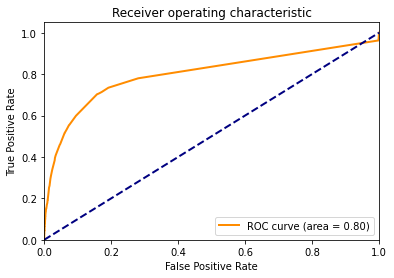

In [71]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

# Recommendation Application 

http://m.shahin.pt/